In [1]:
# Show plots inline, and load main getdist plot module and samples class
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pylab as mplot
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True



%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (16.,8.)
#import config

from chainconsumer import ChainConsumer


GetDist Version: 1.3.4, Matplotlib version: 3.1.1


In [2]:
def get_names(filename):
    """
    Function to obtain the names of the parameters of your chain
    """
    data = np.genfromtxt(filename, names=True)
    names = np.array(data.dtype.names)
    #print(names)
    #print(len(names))
    return names

def get_indices(filename, list_vars):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    return indices

def get_om_s8(filename):
    # might be useful later..
    data = np.loadtxt(filename)
    nsample = get_nsample(filename)
    data_params = []
    data_params.append([data[-nsample:,0], data[-nsample:,-3]*(data[-nsample:,0]/0.3)**(0.5)])
    data_params = np.array(data_params[0][:]).T
    weights = data[-nsample:,-1]
    return data_params, weights

def compute_s8(om, sigma_8):
    return sigma_8*(om/0.3)**0.5

In [12]:
dir = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/'
nlbins = 5

name_plots = 'gs-comb'

chainfile_0 = dir + 'gaussian_sims_3x2pt_fourier_lcdm.txt'
name_0 = r'$\Lambda$CDM Fourier'

chainfile_1 = dir + 'gaussian_sims_3x2pt_real.txt'
name_1 = r'$\Lambda$CDM Real'

chainfile_2 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt'
name_2 = r'$w$CDM Fourier'

chainfile_3 = dir + 'gaussian_sims_3x2pt_real_w0-wa.txt'
name_3 = r'$w$CDM Real'

#chainfile_4 = dir + 'prior_3x2pt_lcdm.txt'
#name_4 = r'Prior'


#chainfile_3 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa_fixed_sys.txt'
#name_3 = r'Fourier space fixed sys.'

#chainfile_1 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt' #this had wider priors on ns and omega_b
#name_1 = r'Fourier $w$CDM'

colors = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']


In [4]:
chain_0 = np.loadtxt(chainfile_0)
chain_1 = np.loadtxt(chainfile_1)
chain_2 = np.loadtxt(chainfile_2)
chain_3 = np.loadtxt(chainfile_3)
#chain_4 = np.loadtxt(chainfile_4)
print(len(chain_0))
print(len(chain_1))
print(len(chain_2))
print(len(chain_3))
#print(len(chain_4))

443520
453600
256640
259600


In [5]:
get_names(chainfile_0)

array(['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
       'cosmological_parametersn_s', 'cosmological_parametersa_s',
       'cosmological_parametersh0', 'firecrown_two_pointia_bias',
       'firecrown_two_pointalphaz',
       'firecrown_two_pointsource_0_mult_bias',
       'firecrown_two_pointsource_1_mult_bias',
       'firecrown_two_pointsource_2_mult_bias',
       'firecrown_two_pointsource_3_mult_bias',
       'firecrown_two_pointsource_4_mult_bias',
       'firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
       'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
       'firecrown_two_pointlens_4_bias',
       'firecrown_two_pointlens_0_delta_z',
       'firecrown_two_pointlens_1_delta_z',
       'firecrown_two_pointlens_2_delta_z',
       'firecrown_two_pointlens_3_delta_z',
       'firecrown_two_pointlens_4_delta_z',
       'firecrown_two_pointsource_0_delta_z',
       'firecrown_two_pointsource_1_delta_z',
       'firec

In [6]:
def get_cosmopars(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'cosmological_parametersh0',
                  'cosmological_parametersomega_b', 'cosmological_parametersn_s','COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_reduced(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars

def get_pars(chainfile, parnames, burnin, chain):
    indices = get_indices(chainfile, parnames)    
    chain_sel = chain[burnin:,indices]
    chain_sel.T[3] = chain_sel.T[3]*10**9  #normalize A_s
    return chain_sel

    

# Plot the rest of the parameters

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $m_1$ & $m_2$ & $m_3$ & $m_4$ & $m_5$ \\ 
		\hline
		Prior & $0.001\pm 0.021$ & $0.000\pm 0.020$ & $0.000\pm 0.022$ & $0.000\pm 0.021$ & $0.000\pm 0.022$ \\ 
		$\Lambda$CDM Fourier & $-0.003^{+0.015}_{-0.014}$ & $-0.002^{+0.013}_{-0.012}$ & $0.015\pm 0.011$ & $\left( -0.3^{+7.5}_{-8.3} \right) \times 10^{-3}$ & $\left( -6.0^{+6.8}_{-6.4} \right) \times 10^{-3}$ \\ 
		$w$CDM Fourier & $0.002^{+0.013}_{-0.014}$ & $-0.004^{+0.015}_{-0.013}$ & $0.011\pm 0.011$ & $\left( -0.4^{+8.9}_{-8.6} \right) \times 10^{-3}$ & $\left( -4.5^{+7.6}_{-8.4} \right) \times 10^{-3}$ \\ 
		$\Lambda$CDM Real & $-0.002^{+0.014}_{-0.013}$ & $-0.003\pm 0.012$ & $0.007\pm 0.010$ & $\left( 1.4^{+8.0}_{-8.4} \right) \times 10^{-3}$ & $\left( -6.5\pm 7.0 \right) \times 10^{-3}$ \\ 
		$w$CDM Real & $-0.002^{+0.014}_{-0.013}$ & $-0.005^{+0.013}_{-0.014}$ & $0.005\pm 0.011$ & $\left( 2.3\pm 9.2 \

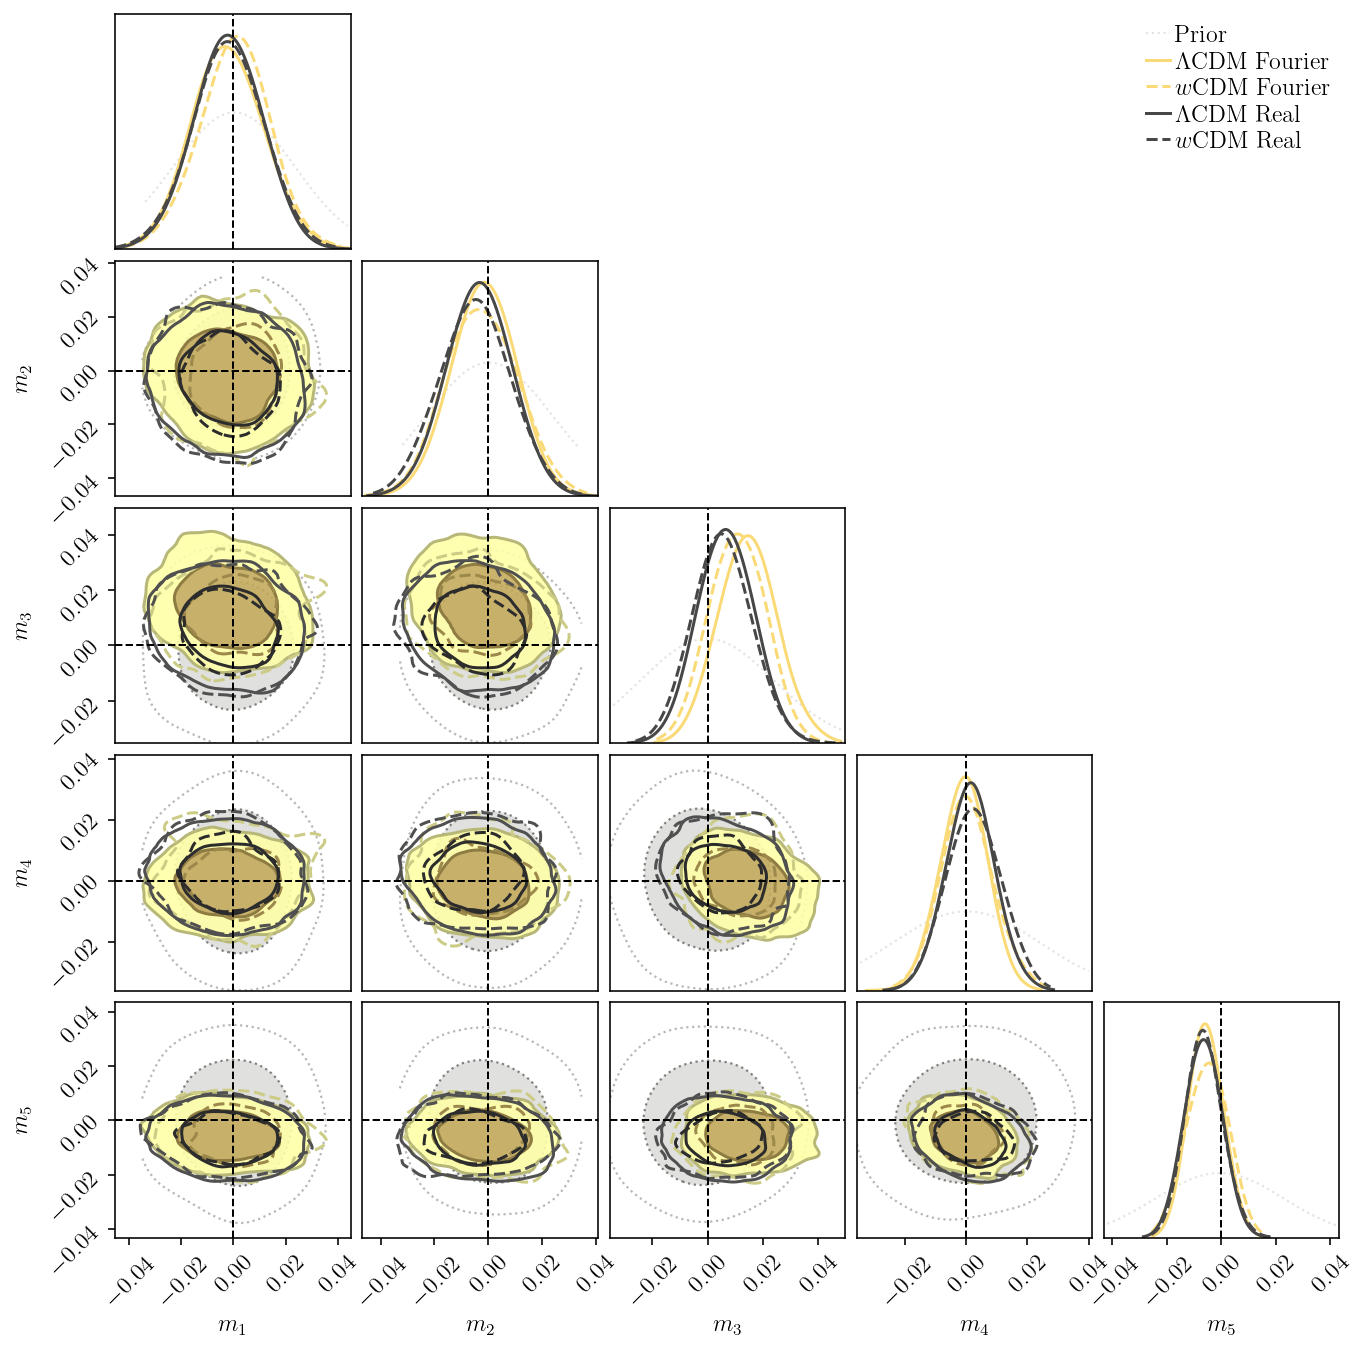

In [22]:
# With EMCEE there are no weights
# Cosmo parameters
parnames = ['firecrown_two_pointsource_0_mult_bias',
       'firecrown_two_pointsource_1_mult_bias',
       'firecrown_two_pointsource_2_mult_bias',
       'firecrown_two_pointsource_3_mult_bias',
       'firecrown_two_pointsource_4_mult_bias']
names = ['$m_1$', '$m_2$', '$m_3$', '$m_4$', '$m_5$']
truths = [0., 0., 0., 0., 0.]

# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

widths = np.array([0.013]*len(truths))
prior = np.random.multivariate_normal(truths,np.diagflat(widths**2),1000)

pars0 = get_indices(chainfile_0, parnames)
pars1 = get_indices(chainfile_1, parnames)
pars2 = get_indices(chainfile_2, parnames)
pars3 = get_indices(chainfile_3, parnames)

c = ChainConsumer()
c.add_chain(prior, parameters=names, name='Prior')
c.add_chain(chain_0[burnin:,pars0], parameters=names, name=name_0)
c.add_chain(chain_2[burnin:,pars2], parameters=names, name=name_2)
c.add_chain(chain_1[burnin:,pars1], parameters=names, name=name_1)
c.add_chain(chain_3[burnin:,pars3], parameters=names, name=name_3)


def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, True,False,False,False,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=[ "#E5E4E2", colors[3],colors[3], colors[0],  colors[0]],legend_kwargs={"fontsize": 12},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.1, 1.5, 1.5,1.5, 1.5, 1], linestyles=[":", "-", "--","-", "--","-", "-", "--",":"])
    return c


c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)
fig = c.plotter.plot(figsize=(5,5), truth=truths) #extents=[(0.18, 0.27), (0.032, 0.058), (0.7, 0.9), (1.3, 3.1), (0.87, 1.06), (0.64, 0.82), (0.23, 0.31), (-1.6, -0.33), (-1.8, 1.)])
fig.set_size_inches(5. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_ms.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_ms.pdf'%(name_plots, burnin), bbox_inches="tight")

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $b_1$ & $b_2$ & $b_3$ & $b_4$ & $b_5$ \\ 
		\hline
		Fourier space & $1.247^{+0.029}_{-0.030}$ & $1.383^{+0.030}_{-0.031}$ & $1.523^{+0.031}_{-0.034}$ & $1.669^{+0.033}_{-0.037}$ & $1.820^{+0.036}_{-0.037}$ \\ 
		Real space & $1.239^{+0.029}_{-0.030}$ & $1.382^{+0.030}_{-0.028}$ & $1.514^{+0.029}_{-0.030}$ & $1.654^{+0.032}_{-0.030}$ & $1.802^{+0.036}_{-0.035}$ \\ 
		\hline
    \end{tabular}
\end{table}


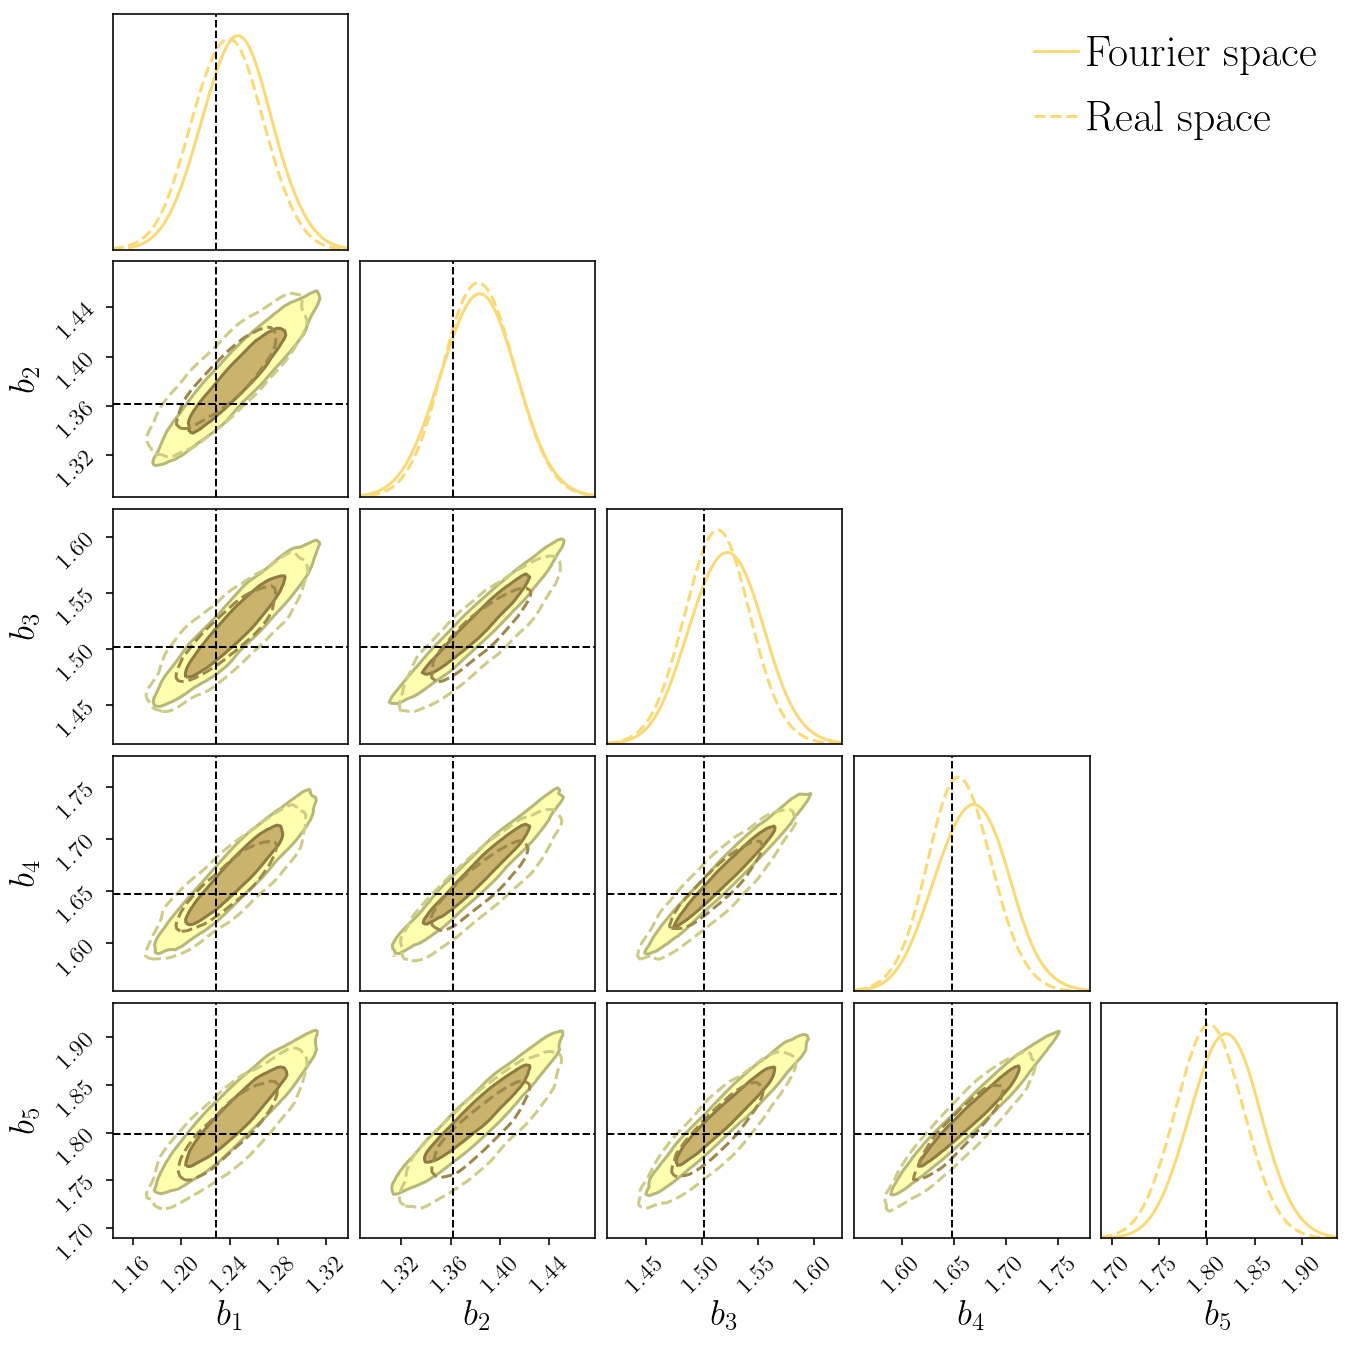

In [62]:
parnames = ['firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
       'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
       'firecrown_two_pointlens_4_bias']
names = ['$b_1$', '$b_2$', '$b_3$', '$b_4$', '$b_5$']
truths = [1.229, 1.362, 1.502, 1.648, 1.799]

# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

pars0 = get_indices(chainfile_0, parnames)
pars1 = get_indices(chainfile_1, parnames)

c = ChainConsumer()

c.add_chain(chain_0[burnin:,pars0], parameters=names, name=name_0)
c.add_chain(chain_1[burnin:,pars1], parameters=names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=[ colors[3],colors[3], colors[0],  colors[0]],legend_kwargs={"fontsize": 12},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.5, 1.5,1.5, 1.5, 1], linestyles=["-", "--","-", "--","-", "-", "--",":"])
    return c


c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)
fig = c.plotter.plot(figsize=(5,5), truth=truths) #extents=[(0.18, 0.27), (0.032, 0.058), (0.7, 0.9), (1.3, 3.1), (0.87, 1.06), (0.64, 0.82), (0.23, 0.31), (-1.6, -0.33), (-1.8, 1.)])
fig.set_size_inches(5. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_bias.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_bias.pdf'%(name_plots, burnin), bbox_inches="tight")

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccccc}
        \hline
		Model & $\Delta_{z_l^1}$ & $\Delta_{z_l^2}$ & $\Delta_{z_l^3}$ & $\Delta_{z_l^4}$ & $\Delta_{z_l^5}$ & $\Delta_{z_s^1}$ & $\Delta_{z_s^2}$ & $\Delta_{z_s^3}$ & $\Delta_{z_s^4}$ & $\Delta_{z_s^5}$ \\ 
		\hline
		Prior & $0.000\pm 0.011$ & $0.000\pm 0.011$ & $0.000\pm 0.014$ & $0.001\pm 0.015$ & $-0.001^{+0.018}_{-0.017}$ & $\left( 0.1^{+4.3}_{-4.4} \right) \times 10^{-3}$ & $\left( 0.1\pm 4.9 \right) \times 10^{-3}$ & $\left( 0.1^{+5.5}_{-5.6} \right) \times 10^{-3}$ & $\left( 0.0^{+6.7}_{-6.8} \right) \times 10^{-3}$ & $\left( 0.2\pm 8.5 \right) \times 10^{-3}$ \\ 
		$\Lambda$CDM Fourier & $\left( -0.3\pm 4.9 \right) \times 10^{-3}$ & $\left( -2.4\pm 5.5 \right) \times 10^{-3}$ & $\left( 1.1^{+6.9}_{-6.1} \right) \times 10^{-3}$ & $\left( -4.8^{+7.3}_{-7.0} \right) \times 10^{-3}$ & $-0.002\pm 0.011$ & $\left( -0.6\pm 2.8 \right) \times 10^{-3}$ & $\left( -0.7\pm 2

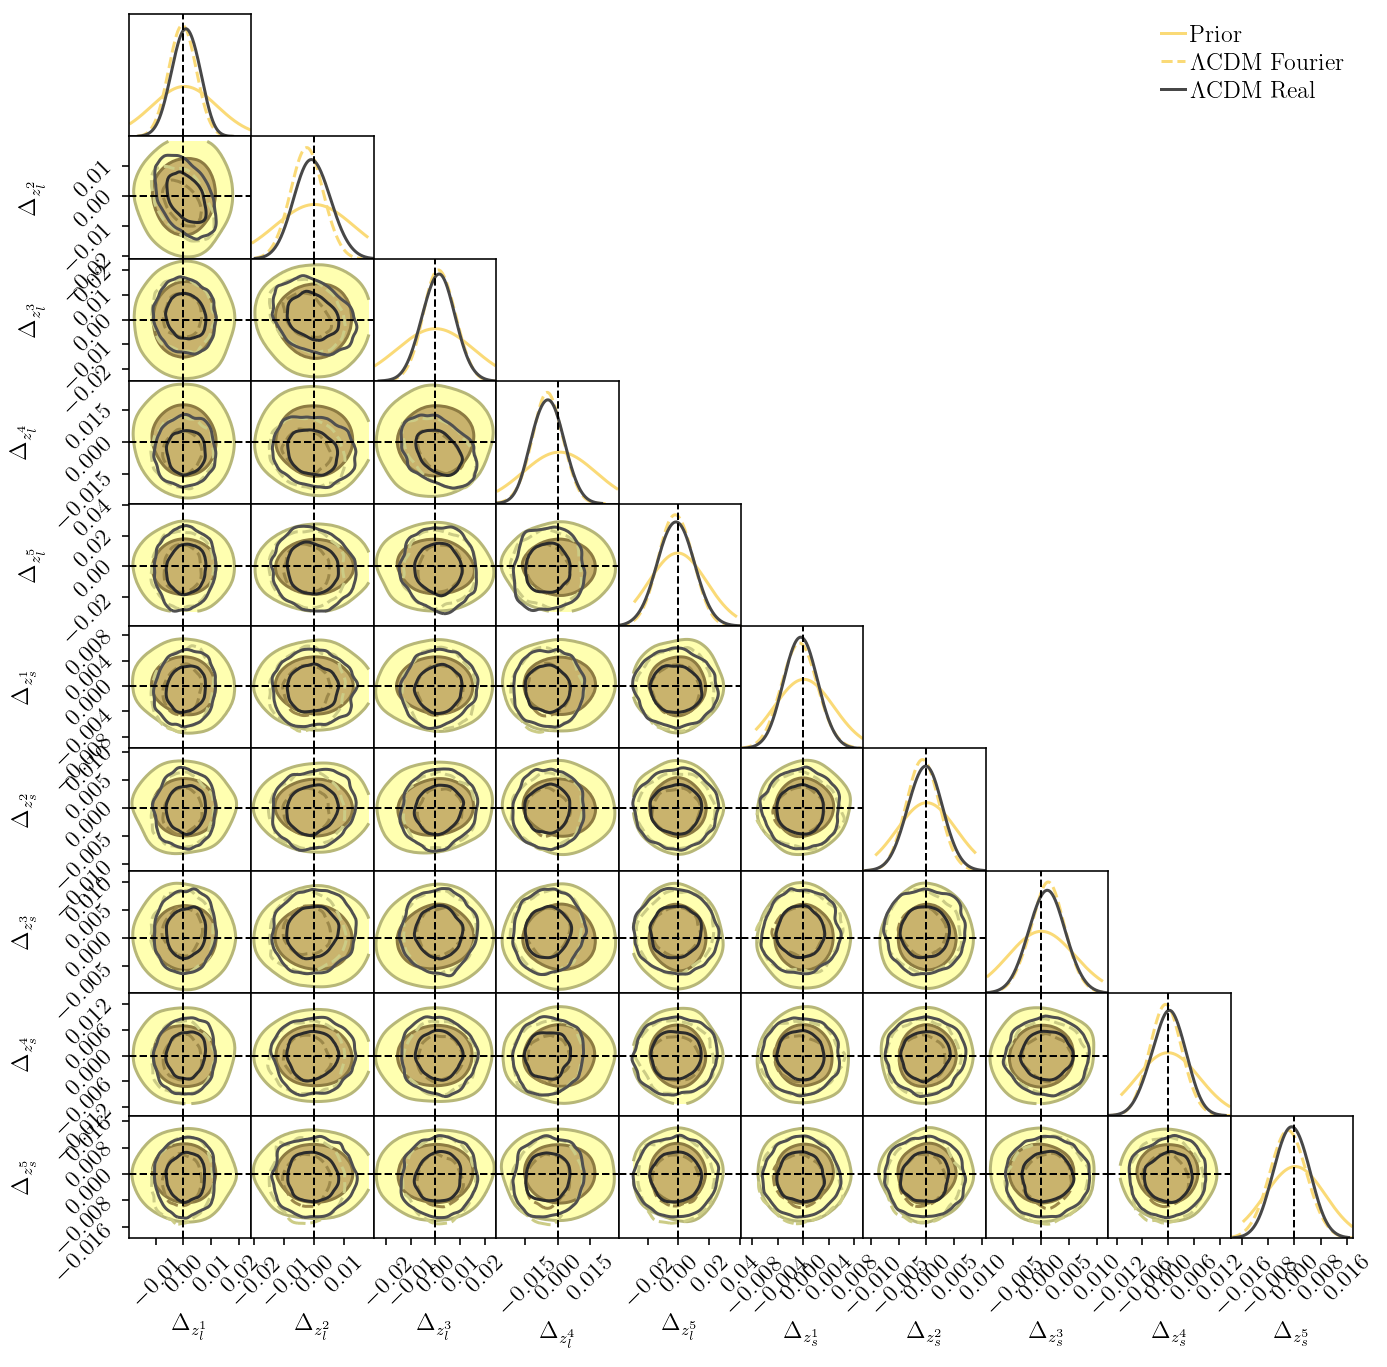

In [23]:
parnames = ['firecrown_two_pointlens_0_delta_z',
       'firecrown_two_pointlens_1_delta_z',
       'firecrown_two_pointlens_2_delta_z',
       'firecrown_two_pointlens_3_delta_z',
       'firecrown_two_pointlens_4_delta_z',
       'firecrown_two_pointsource_0_delta_z',
       'firecrown_two_pointsource_1_delta_z',
       'firecrown_two_pointsource_2_delta_z',
       'firecrown_two_pointsource_3_delta_z',
       'firecrown_two_pointsource_4_delta_z']

names = ['$\Delta_{z_l^1}$', '$\Delta_{z_l^2}$', '$\Delta_{z_l^3}$', '$\Delta_{z_l^4}$', '$\Delta_{z_l^5}$',
        '$\Delta_{z_s^1}$', '$\Delta_{z_s^2}$', '$\Delta_{z_s^3}$', '$\Delta_{z_s^4}$', '$\Delta_{z_s^5}$']
truths = np.array([0]*len(parnames))

# Lens then source
widths = np.array([0.0066,0.0075,0.0085, 0.0095,0.0105, 0.0026, 0.003, 0.0034, 0.0039, 0.0052])
prior = np.random.multivariate_normal(truths,np.diagflat(widths**2),1000)

# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

pars0 = get_indices(chainfile_0, parnames)
pars1 = get_indices(chainfile_1, parnames)

c = ChainConsumer()
c.add_chain(prior, parameters=names, name='Prior')
c.add_chain(chain_0[burnin:,pars0], parameters=names, name=name_0)
c.add_chain(chain_1[burnin:,pars1], parameters=names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=[ colors[3],colors[3], colors[0],  colors[0]],legend_kwargs={"fontsize": 12},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.5, 1.5,1.5, 1.5, 1], linestyles=["-", "--","-", "--","-", "-", "--",":"])
    return c


c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)
fig = c.plotter.plot(figsize=(5,5), truth=truths) #extents=[(0.18, 0.27), (0.032, 0.058), (0.7, 0.9), (1.3, 3.1), (0.87, 1.06), (0.64, 0.82), (0.23, 0.31), (-1.6, -0.33), (-1.8, 1.)])
fig.set_size_inches(5. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_deltazs.png'%(name_plots, burnin), bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_deltazs.pdf'%(name_plots, burnin), bbox_inches="tight")

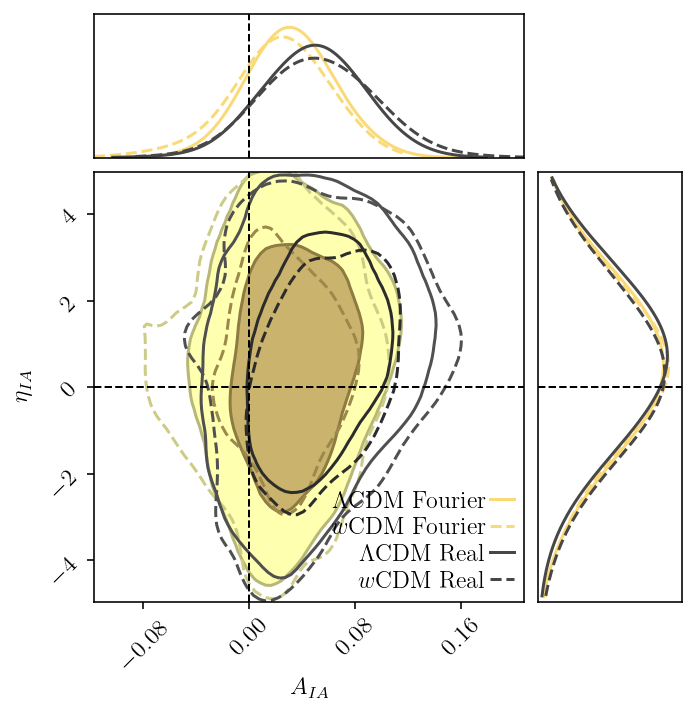

In [21]:
parnames = ['firecrown_two_pointia_bias',
       'firecrown_two_pointalphaz']
names = ['$A_{IA}$', r'$\eta_{IA}$']
truths = [0., 0.]

# With EMCEE there are no weights
# Cosmo parameters
burnin = 150000

pars0 = get_indices(chainfile_0, parnames)
pars1 = get_indices(chainfile_1, parnames)
pars2 = get_indices(chainfile_2, parnames)
pars3 = get_indices(chainfile_3, parnames)
c = ChainConsumer()

c.add_chain(chain_0[burnin:,pars0], parameters=names, name=name_0)
c.add_chain(chain_2[burnin:,pars2], parameters=names, name=name_2)
c.add_chain(chain_1[burnin:,pars1], parameters=names, name=name_1)
c.add_chain(chain_3[burnin:,pars3], parameters=names, name=name_3)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=[ colors[3],colors[3],  colors[0],  colors[0]],legend_kwargs={"fontsize": 12, "loc":'lower right'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.5, 1.5,1.5, 1.5, 1], linestyles=["-", "--","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
#table = c.analysis.get_latex_table()
#print(table)
fig = c.plotter.plot(figsize=(2.8,2.8), truth=truths) #extents=[(0.18, 0.27), (0.032, 0.058), (0.7, 0.9), (1.3, 3.1), (0.87, 1.06), (0.64, 0.82), (0.23, 0.31), (-1.6, -0.33), (-1.8, 1.)])
fig.set_size_inches(2. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_ia.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_ia.pdf'%(name_plots, burnin),  bbox_inches="tight")

In [18]:
"#FEB580"

'#FEB580'